<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/part9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal self attention mechanism

* causal attentiion, also known as masked attention is a special form of selt attention.

* It restricts the model to only consider previous and current inputs in a sequence, when processing any given token.

* This is contrast to the self attention mechanism, which allows access to the entire input sequence at once.

* When computing attention scores, the causal attention mechanism ensures that model only factors in tokens that occur at or before the current token in the sequence.

* To achieve this in GPT like LLMs, for each token processed, we mask out the future tokens, which come after the current token in the input text.

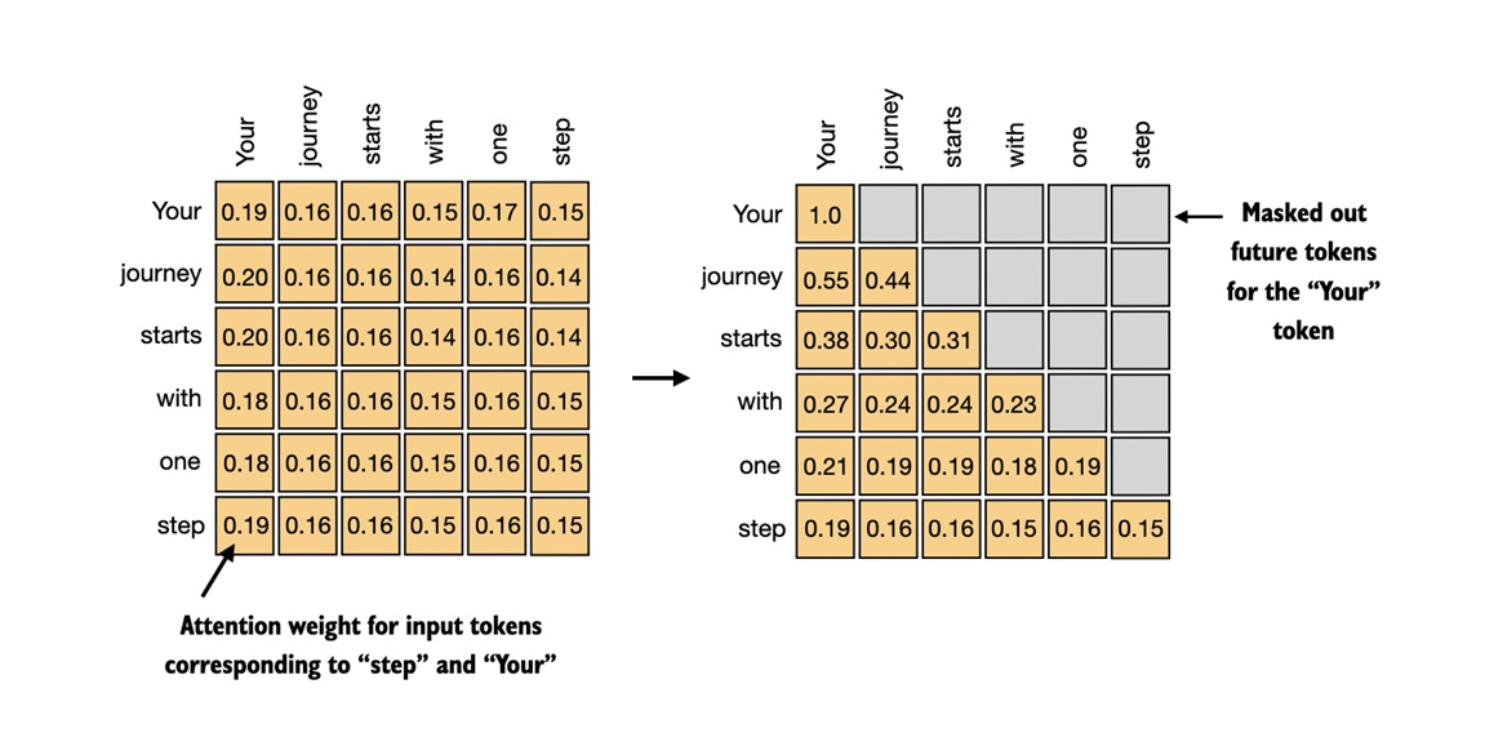

We mask out the attention weights above the diagonal, and we normalize the non masked attention weights, such that the attention weights sum upto 1 in each row.

## Applying causal attention mask

Get attention weights as done previously, zero out elements above the diagonal and normalize the resulting matrix.

**Hiding future words with causal attention**

In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [2]:
import torch.nn as nn

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [3]:
d_in = inputs.shape[1]
d_out = 2

In [4]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [5]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
values = sa_v2.W_value(inputs)

In [6]:
print(queries)

tensor([[ 0.6600, -0.2047],
        [ 0.9091, -0.4471],
        [ 0.8960, -0.4419],
        [ 0.5034, -0.2633],
        [ 0.4088, -0.2232],
        [ 0.6628, -0.3292]], grad_fn=<MmBackward0>)


In [7]:
attn_scores = queries @ keys.T
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [8]:
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [9]:
masked_attn_weights = torch.tril(attn_weights)
print(masked_attn_weights)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<TrilBackward0>)


In [10]:
row_sums = masked_attn_weights.sum(dim=1, keepdim=True)
print(row_sums)
masked_attn_weights_norm = masked_attn_weights / row_sums
print(masked_attn_weights_norm)

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


Idea of causal attention is to not have any influence of future inputs but if we can see properly we have done softmax in attention weights before applying masking and that has influence of future inputs.

This is a **data leakage** problem.

Better way to do:

1. Attention scores
2. Upper Triangular infinity mask
3. Softmax

The softmax function converts its inputs into a probability distribution.

When negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability.  (Mathematically, this is because e-∞ approaches 0.)

We can implement this more efficient masking "trick" by creating a mask with 1's above the diagonal and then replacing these 1's with negative infinity (-inf) values:

In [18]:
mask = torch.triu(torch.ones(6, 6), diagonal=1)
print(mask)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [19]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [23]:
masked = attn_scores.masked_fill(mask == 1, -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [27]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero.

The softmax function then recalculates attention weights only among the unmasked tokens.

This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

### Masking additional attention weights with dropout

- Dropout is a deep learning technique where randomly selected hidden liayer units are ignored during training.
- This process prevents overfitting and improves generalization performance.

In transformer architecture, including models like GPT, dropout in the attention mechanism is applied in 2 specific areas:
- after calculating attention scores
- after applying attention weights to value vectors.

In the following code example, we use a dropout rate of 50%, which means masking out half of the attention weights.

When we train the GPT model in later chapters, we will use a
lower dropout rate, such as 0.1 or 0.2.

In [36]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
print(dropout)
example = torch.ones(6, 6) #B
print(example)
print(dropout(example))

Dropout(p=0.5, inplace=False)
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


# 🧠 Why Dropout Scales by (1 / (1 - p))

## 🔹 What Dropout Does

* Randomly **drops (zeros out)** some neuron activations during training.
* Each activation is **kept** with probability ( (1 - p) ) and **dropped** with probability ( p ).

Example:
`Dropout(p=0.5)` → keeps 50% of neurons, drops 50%.

---

## 🔹 The Problem Without Scaling

If we just zero out some activations without scaling, the **average output** (expected value) becomes smaller.

| Case    | Probability | Output |
| ------- | ----------- | ------ |
| Dropped | 0.5         | 0      |
| Kept    | 0.5         | 1      |


E[x] = (0.5 * 0) + (0.5 * 1) = 0.5

Expected value decreases by half → the next layer receives weaker signals.

---

## 🔹 The Fix: Scale by ( 1 / (1 - p) )

To keep the average signal strength the same, we scale up the neurons that survive.

| Case    | Probability | Output (scaled) |
| ------- | ----------- | --------------- |
| Dropped | 0.5         | 0               |
| Kept    | 0.5         | 2               |

[
E[x] = (0.5 * 0) + (0.5 * 2) = 1.0
]

✅ Now the **expected output** matches the original (1.0).

---

## 🔹 General Rule

Dropout output =
\begin{cases}
0, & \text{with probability } p \
\frac{x}{1-p}, & \text{with probability } (1-p)
\end{cases}

This ensures: E[Dropout(x)] = x


---

## 💡 Intuitive Analogy

> Imagine 10 light bulbs, each with brightness 1.
> Dropout randomly turns off half (p=0.5).
> To keep the room equally bright, the remaining 5 bulbs shine **twice as bright** (×2).

That’s exactly what scaling by (1/(1-p)) does. 💡

In [37]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


## Implement causal attention class

Before we begin, one more thing is to ensure that the code can handle batches consisting of more than one input.

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

For simplicity, to simulate such batch inputs, we duplicate the input text example:

2 inputs with 6 tokens each, and each token has embedding dimension 3

In [38]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [44]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
      b, num_tokens, d_in = x.shape
      keys = self.W_key(x)
      queries = self.W_query(x)
      values = self.W_value(x)

      attn_scores = queries @ keys.transpose(1, 2) # only interested in num_tokens and d_in so that's why pass index 1 and 2

      attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size

      attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
      context_vec = attn_weights @ values

      return context_vec


In [45]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


The use of register_buffer in PyTorch is not strictly necessary for all use cases but offers several advantages here.

For instance, when we use the CausalAttention class in our LLM, buffers are automatically moved to the appropriate device (CPU or GPU) along with our model, which will be relevant when training the LLM in future chapters.

This means we don't need to manually ensure these tensors are on the same device as your model parameters, avoiding device mismatch errors.